## Comprehensive Analysis of Dual-Function AMPs (antimicrobial and anticancer activity)

## 1 Introduction

**This notebook includes:**
- Feauture extraction from peptide sequences

- Pairwise aligment of AMPs with dual activity and AMPs with "antimicrobial" activity

- Descriptor-based feature extraction

- Positive charge distribution analysis 

- BLAST alignment against non-dual-function AMPs



## 2 Methods

### 2.1 Preparing the DataFrames (data Colection)

- Load a general AMP dataset ("general_amps2.xlsx") extracted from DRAMP.

- Filter and save peptides that have both "antimicrobial" and "anticancer" activity based on the Activity column.

- Load additional peptides collected from a literature review (dados.xlsx).

- Combine the filtered and literature-derived peptides into a single dataset.

- Remove duplicate sequences.

- Save the final dataset to filtered_amps_updated.xlsx.



In [46]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [47]:
# Import the pandas library for data manipulation and analysis

import pandas as pd

#  Load data from Excel files into pandas DataFrames

df = pd.read_excel("general_amps2.xlsx")

# Filter AMPs with both antimicrobial and anticancer activity
filtered_df = df[
    df['Activity'].str.contains('antimicrobial', case=False, na=False) &
    df['Activity'].str.contains('anticancer', case=False, na=False)
]

# Save the filtered AMPs to a new Excel file
filtered_df.to_excel("filtered_dual_activity_amps.xlsx", index=False)
print(f"Filtered {len(filtered_df)} peptides with dual activity saved to 'filtered_dual_activity_amps.xlsx'.")

# Load additional peptide data from literature review
additional_df = pd.read_excel("dados.xlsx")

# Combine both datasets and remove duplicates based on 'Sequence'
combined_df = pd.concat([filtered_df, additional_df], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset='Sequence')

# Save the final combined dataset
combined_df.to_excel("filtered_amps_updated.xlsx", index=False)
print(f"Final dataset saved to 'filtered_amps_updated.xlsx'.")
print(f"Total unique peptides (by sequence): {len(combined_df)}")


Filtered 3894 peptides with dual activity saved to 'filtered_dual_activity_amps.xlsx'.
Final dataset saved to 'filtered_amps_updated.xlsx'.
Total unique peptides (by sequence): 3303


In [48]:
import pandas as pd

df = pd.read_excel("filtered_amps_updated.xlsx")
df['Sequence'] = df['Sequence'].astype(str).str.replace('\xa0', '', regex=False).str.replace(' ', '', regex=False).str.strip()
df = df.drop_duplicates(subset='Sequence')
df.to_excel("filtered_amps_cleaned_unique_sequences.xlsx", index=False)



### 2.2 Pairwise aligment of filtred AMPs with dual activity and AMPs with "antimicrobial" activity

- Load a general AMP dataset ("general_amps2.xlsx") 

- Filters the dataset to retain only peptides with antimicrobial activity, possibly alongside other functions ("antimicrobial_df.xlsx").

- Removes non-standard characters and whitespace from peptide sequences ("simple_amps.fasta")

- Implements a function to compute percentage identity between two sequences based on their aligned positions.

- Perform Pairwise Sequence Alignments (dual_peptides.fasta) against the cleaned AMP dataset.

- Calculates and classifies the global alignment and percent identity for each peptide pair.

- Saves the alignment results to two tab-separated files:

        strict.tsv for high-identity alignments

        relaxed.tsv for moderate-identity alignments

        

In [14]:
import pandas as pd
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# == 1. Load data from Excel files into pandas DataFrames

df = pd.read_excel("general_amps2.xlsx")

# Filter the "Activity" column to include AMPs that have antimicrobial activity alone or in combination with other activities 

antimicrobial_df = df[df['Activity'].str.contains('antimicrobial', case=False, na=False)].copy()

antimicrobial_df.to_excel("antimicrobial_df.xlsx", index=False)


# === 2. # Function to clean the DataFrame by removing duplicates and unwanted characters from sequences and saving as fasta records

antimicrobial_df['Sequence'] = antimicrobial_df['Sequence'].astype(str).apply(
    lambda s: ''.join(c for c in s if c.isascii() and not c.isspace())
)

simple_records = [
    SeqRecord(Seq(seq), id=f"amp_{i}", description="")
    for i, seq in enumerate(antimicrobial_df['Sequence'])
]
SeqIO.write(simple_records, "simple_amps.fasta", "fasta")

# == 3. Function to calculate percentage identity between two sequences based on their alignment

def percent_identity(seq1, seq2, aln):
    matches = sum(a == b for a, b in zip(aln.seqA, aln.seqB))
    length = max(len(seq1), len(seq2))
    return matches / length * 100

# === 4. Pairwise global alignment between dual-function AMPs sequences and AMP, categorizing matches based on 
        # percent identity into strict (≥90%) and relaxed (50–89.99%) result sets

dual_records = list(SeqIO.parse("dual_peptides.fasta", "fasta"))
db_records = list(SeqIO.parse("simple_amps.fasta", "fasta"))

strict_results = []   # Identity ≥ 90%
relaxed_results = []  # Identity ≥ 50% and < 90%

for query in dual_records:
    for subject in db_records:
        alignments = pairwise2.align.globalxx(query.seq, subject.seq, one_alignment_only=True)
        if not alignments:
            continue
        aln = alignments[0]
        pid = percent_identity(query.seq, subject.seq, aln)

        result = {
            "query_id": query.id,
            "subject_id": subject.id,
            "percent_identity": round(pid, 2),
            "alignment_length": len(aln.seqA),
            "matches": aln.score
        }

        if pid >= 90:
            strict_results.append(result)
        elif pid >= 50:
            relaxed_results.append(result)

# === 5. Save the alignment results ===

df_strict = pd.DataFrame(strict_results)
df_relaxed = pd.DataFrame(relaxed_results)

df_strict.to_csv("strict.tsv", sep="\t", index=False)
df_relaxed.to_csv("relaxed.tsv", sep="\t", index=False)

print(f"High-similarity alignments (≥90% identity): {len(df_strict)}")
print(f"Moderate-similarity alignments (≥50% identity): {len(df_relaxed)}")


/opt/homebrew/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


High-similarity alignments (≥90% identity): 32665
Moderate-similarity alignments (≥50% identity): 322842


**Low results**

The alignments with low similarity, as recorded in low.tsv, will constitute the negative dataset. This dataset includes sequences with less than 50% identity, representing weakly related or non-matching alignments. It will be used as a reference for analyses requiring a distinction between low-similarity and high-similarity sequences

In [11]:
import pandas as pd
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# == 1. Load data from Excel files into pandas DataFrames

df = pd.read_excel("general_amps2.xlsx")

# Filter the "Activity" column to include AMPs that have antimicrobial activity alone or in combination with other activities 

antimicrobial_df = df[df['Activity'].str.contains('antimicrobial', case=False, na=False)].copy()

antimicrobial_df.to_excel("antimicrobial_df.xlsx", index=False)


# === 2. # Function to clean the DataFrame by removing duplicates and unwanted characters from sequences and saving as fasta records

antimicrobial_df['Sequence'] = antimicrobial_df['Sequence'].astype(str).apply(
    lambda s: ''.join(c for c in s if c.isascii() and not c.isspace())
)

simple_records = [
    SeqRecord(Seq(seq), id=f"amp_{i}", description="")
    for i, seq in enumerate(antimicrobial_df['Sequence'])
]
SeqIO.write(simple_records, "simple_amps.fasta", "fasta")

# == 3. Function to calculate percentage identity between two sequences based on their alignment

def percent_identity(seq1, seq2, aln):
    matches = sum(a == b for a, b in zip(aln.seqA, aln.seqB))
    length = max(len(seq1), len(seq2))
    return matches / length * 100

# === 4. Pairwise global alignment between dual-function AMPs sequences and AMP, categorizing matches based on 
        # percent identity into low (<50%) result sets

dual_records = list(SeqIO.parse("dual_peptides.fasta", "fasta"))
db_records = list(SeqIO.parse("simple_amps.fasta", "fasta"))

low_results = []  # Identity < 50%

for query in dual_records:
    for subject in db_records:
        alignments = pairwise2.align.globalxx(query.seq, subject.seq, one_alignment_only=True)
        if not alignments:
            continue
        aln = alignments[0]
        pid = percent_identity(query.seq, subject.seq, aln)

        if pid < 50:
            result = {
                "query_id": query.id,
                "subject_id": subject.id,
                "percent_identity": round(pid, 2),
                "alignment_length": len(aln.seqA),
                "matches": aln.score
            }
            low_results.append(result)

# === 5. Save the low alignment results ===

df_low = pd.DataFrame(low_results)
df_low.to_csv("low.tsv", sep="\t", index=False)

print(f"Low-similarity alignments (<50% identity): {len(df_low)}")

/opt/homebrew/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Low-similarity alignments (<50% identity): 36651305


## Aditional step

In [21]:
import pandas as pd

antimicrobial_df = pd.read_excel("antimicrobial_df.xlsx")

if "Sequence" not in antimicrobial_df.columns or "DRAMP_ID" not in antimicrobial_df.columns:
    raise ValueError("The DataFrame must contain 'Sequence' and 'ID' columns.")

# Create FASTA
with open("simple_amps.fasta", "w") as fasta_file:
    for _, row in antimicrobial_df.iterrows():
        fasta_file.write(f">{row['DRAMP_ID']}\n{row['Sequence']}\n")
print("File 'simple_amps.fasta' created successfully.")

File 'simple_amps.fasta' created successfully.


### METADADA file for negative dataset

This script performs a BLASTP analysis to identify low-similarity alignments (<50% identity) between query sequences and a database of antimicrobial peptides. The results are then integrated with a metadata file (antimicrobial_df.xlsx) containing detailed information about the peptides. The final dataset is saved in a separated file (low_similarity_results.tsv) for further analysis.

In [44]:
import pandas as pd
from Bio.Blast.Applications import NcbiblastpCommandline

# Run BLASTP
blastp_cline = NcbiblastpCommandline(
    query="dual_peptides.fasta",  
    db="simple_amps_db",  
    evalue=0.01,
    outfmt=6,  
    max_target_seqs=10000,
    out="blast_results.tsv"
)
stdout, stderr = blastp_cline()

# Load BLAST results
columns = [
    "query_id", "subject_id", "percent_identity", "alignment_length",
    "mismatches", "gap_opens", "q_start", "q_end", "s_start", "s_end",
    "evalue", "bit_score"
]
blast_results = pd.read_csv("blast_results.tsv", sep="\t", names=columns)

# Filter results with percent identity < 50%
low_similarity_results = blast_results[blast_results["percent_identity"] < 50]

# Load antimicrobial metadata
antimicrobial_df = pd.read_excel("antimicrobial_df.xlsx")

# Merge low-similarity results with antimicrobial_df based on subject_id
low_similarity_results = low_similarity_results.merge(
    antimicrobial_df, left_on="subject_id", right_on="DRAMP_ID", how="left"
)

# Select only the columns from antimicrobial_df
final_results = low_similarity_results[antimicrobial_df.columns]

# Save the final results
final_results.to_csv("low_similarity_results.tsv", sep="\t", index=False)

# Print the number of low-similarity alignments
print(f"Low-similarity alignments (<50% identity): {len(final_results)}")

Low-similarity alignments (<50% identity): 2721


To prepare the dataset for machine learning, it is essential to ensure consistency in the structure of the data. This script filters the low-similarity BLAST results to retain only the columns that match the structure of the original metadata (antimicrobial_df). By keeping only the relevant columns, the resulting dataset will be uniform and ready for further processing in machine learning models.

In [19]:
import pandas as pd

# Load the low-similarity results
low_similarity_results = pd.read_csv("low_similarity_results.tsv", sep="\t")

# Define the desired columns to keep
desired_columns = [
    "DRAMP_ID", "Sequence", "Sequence_Length", "Name", "Swiss_Prot_Entry", 
    "Family", "Gene", "Source", "Activity", "Protein_existence", 
    "N-terminal_Modification", "C-terminal_Modification", "Other_Modifications", 
    "Stereochemistry", "Cytotoxicity", "Binding_Traget", "Pubmed_ID", 
    "Reference", "Author", "Title"
]

# Filter the DataFrame to keep only the desired columns
filtered_results = low_similarity_results[desired_columns]

# Save the filtered results to a new file
filtered_results.to_csv("low_similarity_metadata.tsv", sep="\t", index=False)

# Print a success message with the number of records
print(f"File 'low_similarity_metadata.tsv' created successfully with {len(filtered_results)} records.")

File 'low_similarity_metadata.tsv' created successfully with 2721 records.


#### Visualization

The results were merged and analyzed to characterize the distribution of identity scores and alignment lengths across the similarity thresholds. Histogram plots were generated to visualize the frequency distribution of percent identity and alignment length, with clear separation between high and moderate similarity cases.

Steps and description for visualization:
1️⃣	Loads strict and relaxed alignment results.
2️⃣	Merges both datasets into one for combined analysis.
3️⃣	Computes descriptive statistics (mean, median, std, etc.) by identity group.
4️⃣	Generates 2 histograms: one for identity percentage and another for alignment length.
5️⃣	Identifies and saves the top 10 most commonly aligned simple AMPs (subject_id).

High-similarity alignments (≥90% identity): 32665
Moderate-similarity alignments (50–89.99% identity): 322842

--- Summary statistics by group ---
           count       mean        std   min    25%    50%    75%     max
group                                                                    
50–89%  322842.0  67.228535  15.391210  50.0  52.63  62.96  85.19   89.66
≥90%     32665.0  93.894839   2.587716  90.0  92.59  92.59  96.15  100.00


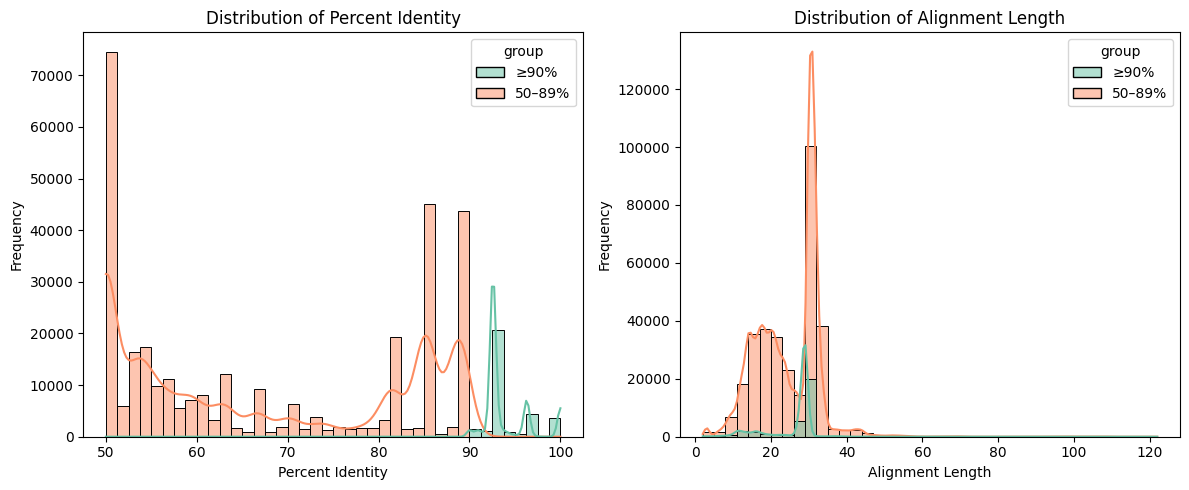


Top 10 most frequently aligned simple AMPs:
subject_id
amp_9293    401
amp_9290    400
amp_9302    400
amp_9292    400
amp_9291    400
amp_9289    400
amp_9288    400
amp_9305    399
amp_9303    399
amp_9304    399
Name: count, dtype: int64


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load alignment results ===
df_strict = pd.read_csv("strict.tsv", sep="\t")
df_relaxed = pd.read_csv("relaxed.tsv", sep="\t")

print(f"High-similarity alignments (≥90% identity): {len(df_strict)}")
print(f"Moderate-similarity alignments (50–89.99% identity): {len(df_relaxed)}")

# === 2. Merge strict and relaxed alignments for combined analysis ===
df_strict["group"] = "≥90%"
df_relaxed["group"] = "50–89%"
df_all = pd.concat([df_strict, df_relaxed], ignore_index=True)

# === 3. Basic statistics ===
print("\n--- Summary statistics by group ---")
print(df_all.groupby("group")["percent_identity"].describe())

# === 4. Visualization ===
plt.figure(figsize=(12, 5))

# Percent identity distribution
plt.subplot(1, 2, 1)
sns.histplot(df_all, x="percent_identity", hue="group", bins=40, kde=True, palette="Set2")
plt.title("Distribution of Percent Identity")
plt.xlabel("Percent Identity")
plt.ylabel("Frequency")

# Alignment length distribution
plt.subplot(1, 2, 2)
sns.histplot(df_all, x="alignment_length", hue="group", bins=40, kde=True, palette="Set2")
plt.title("Distribution of Alignment Length")
plt.xlabel("Alignment Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("pairwise_alignment_histograms.png")
plt.show()

# === 5. Top 10 most frequently aligned AMPs (simple) ===
top_subjects = df_all["subject_id"].value_counts().head(10)
print("\nTop 10 most frequently aligned simple AMPs:")
print(top_subjects)

# === Save detailed output ===
df_all.to_csv("pairwise_all_results.tsv", sep="\t", index=False)
top_subjects.to_csv("top_10_subject_hits.tsv", sep="\t")


**Results:** The density curves indicate that most alignments fall below the 90% identity threshold, highlighting structural diversity among the functional peptides. The alignment length distribution also supports this variability, with longer alignments generally associated with higher identity scores. This suggests that conserved motifs or structural regions may be preserved in subsets of dual-function AMPs.

Additionally, the analysis identified the top 10 most frequently matched AMPs in the reference dataset, providing candidates for further functional analysis or redundancy reduction. These visual and statistical assessments validate the presence of non-trivial similarities among sequences and support the rationale for including homology analysis in the pipeline to reduce bias and ensure model generalizability.

**Identifying New Candidate Dual-Function AMPs via Sequence Alignment**



In [88]:
import pandas as pd

# Load the dataset with confirmed dual-function AMPs
combined_df = pd.read_excel("filtered_amps_updated.xlsx")
combined_seqs = set(
    combined_df['Sequence'].str.replace('\xa0', '', regex=False).str.replace(' ', '', regex=False).str.strip()
)

# Load relaxed alignment results (identity ≥50%)
df_relaxed = pd.read_csv("blast_relaxed2.tsv", sep="\t")

# Load the dataset of all antimicrobial AMPs
antimicrobial_df = pd.read_excel("antimicrobial_df.xlsx")

# Extract subject IDs that aligned with duals
subject_ids = df_relaxed['subject_id'].unique()

# Extract numeric indices (e.g., "amp_1234" → 1234)
indices = [int(s.split("_")[1]) for s in subject_ids if "_" in s and s.split("_")[1].isdigit()]

# Get corresponding sequences from the antimicrobial dataset
aligned_simple_seqs = antimicrobial_df.iloc[indices]['Sequence'].str.replace('\xa0', '', regex=False).str.replace(' ', '', regex=False).str.strip()

# Identify sequences that are not in the confirmed dual-function dataset
new_candidate_seqs = aligned_simple_seqs[~aligned_simple_seqs.isin(combined_seqs)]

# Retrieve full records for these potential new candidates
nem_candidates = antimicrobial_df[
    antimicrobial_df['Sequence'].str.replace('\xa0', '', regex=False).str.replace(' ', '', regex=False).str.strip().isin(new_candidate_seqs)
]

# Export to Excel for exploratory analysis (not added to the main dataset)
nem_candidates.to_excel("new_candidates_dual_fuction.xlsx", index=False)

print(f"{len(nem_candidates)} AMPs align with ≥50% identity but are not in the dual-function dataset.")



4009 AMPs align with ≥50% identity but are not in the dual-function dataset.


### 2. 3 Charge-Based Distribution Descriptor

Grouping residues by charge is a well-established approach in AMP and ACP studies [(Mahlapuu et al., 2016), (Jhong et al., 2019)]. 

        Feature to extract: Distribution of positively charged residues along the sequence.

- Define charge classes for amino acids (positive, negative, neutral).

- Create and aplly a function to compute the distribution of charged residues in peptide sequences.

- Merge the computed charge distribution features with your original dataset.

- Display the updated dataset to verify the added charge distribution descriptors ("final_df.csv").

In [3]:

# Charge classification for amino acids

combined_df = pd.read_excel("filtered_amps_updated.xlsx")

charge_classes = {
    'positive': ['K', 'R', 'H'],
    'negative': ['D', 'E'],
    'neutral':  ['A', 'N', 'C', 'Q', 'G', 'I', 'L', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
}

combined_df['Sequence'] = combined_df['Sequence'].astype(str).str.replace('\xa0', '', regex=False).str.replace(' ', '', regex=False).str.strip()


# Function to compute charge distribution descriptors
def compute_charge_distribution(sequence):
    descriptors = {}
    seq_len = len(sequence)
    
    for label, residues in charge_classes.items():
        # Find positions of all residues of this class
        positions = [i + 1 for i, aa in enumerate(sequence) if aa in residues]
        total = len(positions)
        
        # For distribution, get 5 quantiles
        if total >= 1:
            quantiles = [0, 0.25, 0.5, 0.75, 1]
            for q in quantiles:
                idx = int(q * (total - 1))  # index in sorted list
                pos = positions[idx] / seq_len  # normalize by sequence length
                descriptors[f'{label}_{int(q*100)}%'] = round(pos, 3)
        else:
            # No residues of this class
            for q in [0, 25, 50, 75, 100]:
                descriptors[f'{label}_{q}%'] = 0.0

    return descriptors




#### Positive Charge Distribution

We extract the distribution descriptors of positive charge along each peptide sequence. This feature supports our goal of identifying key structural characteristics associated with dual antimicrobial and anticancer activity.

- Define the Function that calculates the quantile-based distribution of positively charged residues (K, R, H) along a peptide sequence.

- Apply the Function to the DataFrame

- Create a New DataFrame for Charge Distributions:

- Merge the Charge Distribution Data with Original Data:

In [3]:
combined_df = pd.read_excel("filtered_amps_updated.xlsx")

def compute_positive_charge_distribution(sequence):
    """Returns quantile-based distribution of positively charged residues (K, R, H) along the sequence."""
    pos_residues = ['K', 'R', 'H']
    positions = [i + 1 for i, aa in enumerate(sequence) if aa in pos_residues]
    seq_len = len(sequence)
    descriptors = {}
    
    if len(positions) >= 1:
        quantiles = [0, 0.25, 0.5, 0.75, 1]
        for q in quantiles:
            idx = int(q * (len(positions) - 1))  # index in sorted list
            norm_pos = positions[idx] / seq_len  # normalized position (0–1)
            descriptors[f'positive_{int(q * 100)}%'] = round(norm_pos, 3)
    else:
        # No positive residues found
        for q in [0, 25, 50, 75, 100]:
            descriptors[f'positive_{q}%'] = 0.0

    return descriptors

# Apllying

pos_charge_features = combined_df['Sequence'].apply(compute_positive_charge_distribution)
pos_charge_df = pd.DataFrame(pos_charge_features.tolist())


combined_df = pd.concat([combined_df, pos_charge_df], axis=1)

# View the result
combined_df.head()


,DRAMP_ID,Sequence,Sequence_Length,Name,Swiss_Prot_Entry,Family,Gene,Source,Activity,Protein_existence,...,Author,Title,Peptide,Cancer Type,Mechanism,positive_0%,positive_25%,positive_50%,positive_75%,positive_100%
0,DRAMP18494,FIHHIIGGLFSAGKAIHRLIRRRRR,25.0,TP4,L0CKG3,Piscidin,TP4,Oreochromis niloticus (Nile tilapia) (Tilapia ...,"Antibacterial, Antifungal, anticancer, wound h...",Protein level,...,"Chang TW, Wei SY, Wang SH, Wei HM, Wang YJ, Wa...",Hydrophobic residues are critical for the heli...,NaN,NaN,NaN,0.120,0.560,0.720,0.880,1.000
1,DRAMP03573,IGKEFKRIVQRIKDFLRNLVPRTES,25.0,LL-37(13-37)(C-terminal fragment of LL-37; Hum...,"P49913, Q71SN9",Not found,Not found,Homo sapiens (Human),"Antimicrobial, Antibacterial, Anti-Gram-, Anti...",Protein level,...,"Li X, Li Y, Han H, Miller DW, Wang G.",Solution structures of human LL-37 fragments a...,NaN,NaN,NaN,0.120,0.240,0.440,0.520,0.880
2,DRAMP03574,FKRIVQRIKDFLRNLV,16.0,LL-37(17-32)(C-terminal fragment of LL-37; Hum...,"P49913, Q71SN9",Not found,Not found,Homo sapiens (Human),"Antimicrobial, Antibacterial, Anti-Gram-, Anti...",Protein level,...,"Li X, Li Y, Han H, Miller DW, Wang G.",Solution structures of human LL-37 fragments a...,NaN,NaN,NaN,0.125,0.188,0.438,0.562,0.812
3,DRAMP03829,GLKKLLGKLLKKLGKLLLK,19.0,GLK-19,No entry found,Not found,Not found,Synthetic construct,"Antimicrobial, Antibacterial, Anti-Gram-, Anti...",Synthetic,...,"Wang G, Li X, Wang Z.",APD2: the updated antimicrobial peptide databa...,NaN,NaN,NaN,0.158,0.211,0.579,0.632,1.000
4,DRAMP04654,IKLSPETKDNLKKVLKGAIKGAIAVAKMV,29.0,"H-0, Hymenochirin-1B",No entry found,Unknown,Not found,Hymenochirus boettgeri (Congo dwarf clawed frog),"Antimicrobial, Anticancer",Experimental evidence at transcript level,...,"Yulei Li, Yihan Zhang, Minghao Wu, Qi Chang, H...","Improving Selectivity, Proteolytic Stability, ...",NaN,NaN,NaN,0.069,0.276,0.448,0.552,0.931


### Computate distribution descriptors

### Visualization

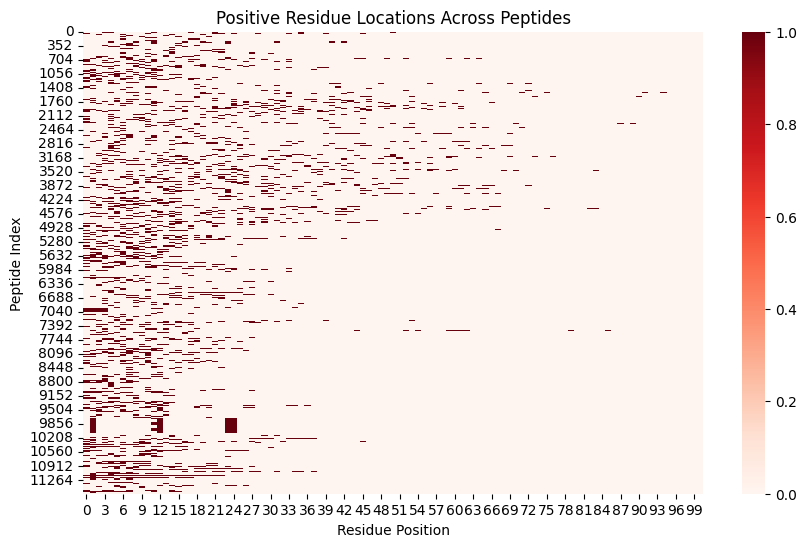

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_positive_positions(sequence):
    """Returns a binary array (length = sequence length) marking positions with K, R, or H."""
    return [1 if aa in ['K', 'R', 'H'] else 0 for aa in sequence]

# Expand all sequences to same length (pad with 0s)
max_len = combined_df['Sequence'].apply(len).max()
heatmap_data = combined_df['Sequence'].apply(get_positive_positions).apply(lambda x: x + [0]*(max_len - len(x)))
heatmap_array = np.array(heatmap_data.tolist())

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_array, cmap='Reds', cbar=True)
plt.title("Positive Residue Locations Across Peptides")
plt.xlabel("Residue Position")
plt.ylabel("Peptide Index")
plt.show()


**Results:** 

The heatmap visualization shows the normalized location of positively charged residues across all peptides in the dataset.

Positively charged residues are broadly distributed across most peptides, reflecting their essential role in interacting with negatively charged cell membranes.

There is a moderate enrichment at the N-terminal region, suggesting enhanced membrane anchoring or cellular penetration potential.

Some peptides show localized clusters of positive residues, potentially linked to mechanisms such as pore formation or selective cytotoxicity.

## 2.4 Similarity Analysis via BLAST: Dual-Activity AMPs vs. Non-AMPs

In this section, we perform a sequence similarity analysis between peptides with dual activity (antimicrobial and anticancer) and a set of negative peptides (with no known biological activity).
The goal is to identify highly similar sequences between these groups, which may indicate false positives, redundant peptides, or common non-discriminative motifs.

We use local BLASTp, comparing the dual-activity AMPs (query) against a database built from the negative peptide dataset (nonamps), ensuring that selected peptides are truly distinctive and suitable for downstream machine learning.

**Negative Dataset from: https://sourceforge.net/projects/axpep/**
                         
                         generated: by running makeblastdb -in filtered_nonAMPs.fasta -dbtype prot -out negative_database.

 ### 1️⃣ Peptide Sequence Cleaning

Ensure that sequences contain only the 20 standard amino acids (A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y).
Sequences containing ambiguous or rare amino acids—such as X (unknown), B (D or N), Z (E or Q), O (pyrrolysine), or U (selenocysteine) can introduce noise or errors.
The script below reads a FASTA file, filters out sequences that contain only valid amino acids, and writes the clean sequences to a new file. It also reports how many sequences were retained and which ones were discarded due to invalid characters

In [91]:
from Bio import SeqIO

input_file = "combined_dual_amps.fasta"
output_file = "dual_clean.fasta"
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")

valid_count = 0

with open(output_file, "w") as output_handle:
    for record in SeqIO.parse(input_file, "fasta"):
        sequence_chars = set(str(record.seq))
        if sequence_chars.issubset(valid_amino_acids):
            SeqIO.write(record, output_handle, "fasta")
            valid_count += 1
        else:
            print(f"{record.id} contains invalid characters: {sequence_chars - valid_amino_acids}")

print(f"\nTotal valid sequences: {valid_count}")


dual_27 contains invalid characters: {'s', 'a', 'g', 'f', 'd', 'v', 'k', 'l', 'i'}
dual_38 contains invalid characters: {'l'}
dual_39 contains invalid characters: {'k', 'l'}
dual_64 contains invalid characters: {'X'}
dual_65 contains invalid characters: {'X'}
dual_72 contains invalid characters: {'r'}
dual_73 contains invalid characters: {'r'}
dual_74 contains invalid characters: {'r'}
dual_75 contains invalid characters: {'k', 'l'}
dual_77 contains invalid characters: {'X'}
dual_78 contains invalid characters: {'X'}
dual_79 contains invalid characters: {'X'}
dual_80 contains invalid characters: {'X'}
dual_89 contains invalid characters: {'f', 'X'}
dual_90 contains invalid characters: {'r', 'w', 'f', 'X', 'O'}
dual_104 contains invalid characters: {'X'}
dual_114 contains invalid characters: {'X'}
dual_115 contains invalid characters: {'X'}
dual_116 contains invalid characters: {'X'}
dual_117 contains invalid characters: {'X'}
dual_118 contains invalid characters: {'X'}
dual_125 contain

### 2️⃣ Comparing Dual-Function Peptides Against a Negative Dataset Using Local BLASTp

This script automates the execution of BLASTp locally using Python, compares the sequences in a query FASTA file (combined_dual_amps.fasta) against a BLAST-formatted protein database (negative_database), and saves the results in a tabular format. 

In [92]:
import subprocess
import os

# Add the BLAST+ binary directory to the system PATH
os.environ["PATH"] += ":/Users/barbarafreitas/ncbi-blast-2.14.1+/bin"

def find_blastp():
    """Attempts to find the blastp executable in the system PATH."""
    blastp_path = subprocess.run("which blastp", shell=True, capture_output=True, text=True)
    
    if blastp_path.returncode == 0:
        return blastp_path.stdout.strip()
    else:
        raise EnvironmentError("blastp could not be found in the system PATH!")

# Locate the blastp executable
blastp = find_blastp()

# Define paths for the query file and the BLAST database
query_file = "combined_dual_amps.fasta"
db_path = "negative_database"  

# Output file for the BLAST results
output_file = "blast_output.txt"

# Construct the BLASTp command with tabular output format
blastp_cmd = [
    blastp,
    "-query", query_file,
    "-db", db_path,
    "-out", output_file,
    "-outfmt", "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore"
]

# Execute the BLASTp command
try:
    subprocess.run(blastp_cmd, check=True)
    print("BLASTp completed successfully.")
except subprocess.CalledProcessError as e:
    print(f"Error during BLASTp execution: {e}")
except EnvironmentError as e:
    print(f"Environment error: {e}")


BLASTp completed successfully.


**Database retrieved from DRAMP:** Ma T, Liu Y, Yu B, Sun X, Yao H, Hao C, Li J, Nawaz M, Jiang X, Lao X, Zheng H. DRAMP 4.0: an open-access data repository dedicated to the clinical translation of antimicrobial peptides. Nucleic Acids Research, Volume 53, Issue D1, 6 January 2025, Pages D403-D410. PMID: 39526377

**Filtering Antimicrobial Peptides by Removing Those with Significant Alignment to Negative Dataset Based on BLAST Results**

In [93]:
# Filter out AMPs that align with negative dataset based on BLAST results
# Load the BLAST results into a DataFrame
blast_results = pd.read_csv("blast_output.txt", sep="\t", header=None, names=["query_id", "subject_id", "percent_identity", "alignment_length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"])

# Define a threshold for significant matches
threshold_identity = 50

# Filter out the query sequences that have high identity alignments with the negative dataset
significant_matches = blast_results[blast_results['percent_identity'] >= threshold_identity]

# Get the list of query IDs to exclude
exclude_ids = significant_matches['query_id'].unique()

# Load the original peptides dataset
df = pd.read_excel("general_amps2.xlsx")

# Filter out the sequences from the dataset that have significant matches
filtered_df = combined_df[~combined_df['Sequence'].isin(exclude_ids)]

# Save the filtered dataset
filtered_df.to_excel("filtered_amps_without_negative_matches.xlsx", index=False)

print(f"Total peptides removed due to high-identity matches: {len(combined_df) - len(filtered_df)}")




Total peptides removed due to high-identity matches: 0


### Coorelation beetween selected feautures

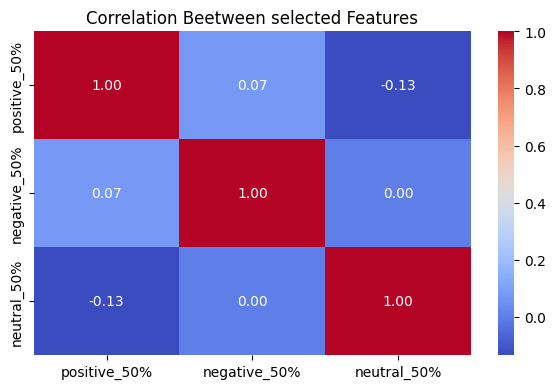

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("final_df.csv")

# Selecting wanted features
selected_features = ['positive_50%', 'negative_50%', 'neutral_50%']
df_selected = df[selected_features].copy()

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=selected_features)

corr_matrix = df_scaled.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Beetween selected Features")
plt.tight_layout()
plt.show()

df_scaled.to_csv("features_scaled.csv", index=False)